<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/Module3/Intro_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import pandas as pd
from scipy import linalg
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.manual_seed(123)
np.random.seed(123)

$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


# Introduction to PyTorch
We will be intoducing PyTorch, "an open source deep learning platform that provides a seamless path from research prototyping to production deployment".

This notebook is by no means comprehensive. If you have any questions the documentation and Google are your friends.



- Automatic differentiation is a powerful tool. 
- PyTorch implements common functions used in deep learning.

## Introduction
### 1. Tensors and relation to numpy
By this point, we have worked with numpy quite a bit. PyTorch's basic building block, the `tensor` is similar to numpy's `ndarray`



In [3]:
# we create tensors in a similar way to numpy nd arrays
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(f"Numpy: {x_numpy}")
print(f"Torch: {x_torch}")
print()

# to and from numpy, pytorch
print('to and from numpy and pytorch')
print(f"Numpy -> Torch: {torch.from_numpy(x_numpy)}")
print(f"Torch -> Numpy: {x_torch.numpy()}")
print()

# we can do basic operations like +-*/
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(f"Numpy: {x_numpy + y_numpy}")
print(f"Torch: {x_torch + y_torch}")
print()

# many functions that are in numpy are also in pytorch
print("norm")
print(f"Numpy: {np.linalg.norm(x_numpy):.6g}")
print(f"Torch: {torch.norm(x_torch):.6g}")
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print("mean along the 0th dimension")
print(f"Numpy: {np.mean(x_numpy, axis=0)}")
print(f"Torch: {torch.mean(x_torch, dim=0)}")


x_numpy, x_torch
Numpy: [0.1 0.2 0.3]
Torch: tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
Numpy -> Torch: tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64)
Torch -> Numpy: [0.1 0.2 0.3]

x+y
Numpy: [3.1 4.2 5.3]
Torch: tensor([3.1000, 4.2000, 5.3000])

norm
Numpy: 0.374166
Torch: 0.374166

mean along the 0th dimension
Numpy: [2. 3.]
Torch: tensor([2., 3.])


### 2. Reshape tensors
We can use the `Tensor.view()` function to reshape tensors similarly to `numpy.reshape()`.

**Change by reference**

Note: A imporant difference between `view` and `reshape` is that `view` returns **reference** to the same tensor as the one passed in. This means that if we modify values in the output of view they will also change for its input. This can lead to some issues. 

Similarly to `reshape` it can also automatically calculate the correct dimension if a -1 is passed in. This is useful if we are working with batches, but the batch size is unknown.





In [4]:
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # automatically choose the 0th dimension

# Alternatively you can use torch.reshape, though it's less commonly used
print(torch.reshape(X, (-1, C, 784)).shape)

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


In [33]:
rand_tensor = torch.rand(4, 4)
new_tensor = rand_tensor.view(1,16)

print (rand_tensor)
# Modifying view tensor changes base tensor as well.
new_tensor[0][0] = -10
print (rand_tensor)

#Note they use the same data storage pointer 
print (rand_tensor.storage().data_ptr())
print (new_tensor.storage().data_ptr())



tensor([[0.1595, 0.0944, 0.6486, 0.6684],
        [0.4630, 0.1783, 0.0708, 0.3777],
        [0.0674, 0.1188, 0.3282, 0.8255],
        [0.2444, 0.2128, 0.0044, 0.5862]])
tensor([[-1.0000e+01,  9.4448e-02,  6.4863e-01,  6.6837e-01],
        [ 4.6299e-01,  1.7829e-01,  7.0838e-02,  3.7770e-01],
        [ 6.7388e-02,  1.1877e-01,  3.2817e-01,  8.2552e-01],
        [ 2.4445e-01,  2.1284e-01,  4.4069e-03,  5.8620e-01]])
121379712
121379712


### 3. PyTorch as an auto-grad framework
Main benefit of PyTorch is that it keeps track of gradients for us, as we do the calculations. This is done through computation graphs. The example below shows how to use these gradients.

Consider the function $f(x)=(x-2)^2$, we want to compute $f'(1)$. 

We make a `backward()` call on the leaf variable (`y`) in the computation, computing all the gradients of `y` at once.






In [5]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('Analytical f\'(x):', fp(x).detach())
print('PyTorch\'s f\'(x):', x.grad)

Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
Analytical f'(x): tensor([-2.])
PyTorch's f'(x): tensor([-2.])


It can also find gradients of functions.

Let $\m{w}=[w_1,w_2]$ and $g(\m{w})= 2w_1w_2+w_2\cos(w_1)$, 
compute $\nabla_{\m{w}}g([\pi,1])$? 

In [6]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)

Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## Example 1: Linear regression using gradient descent with PyTorch
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

Note: This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorch" way in the next example.

But first lets generate synthetic data to solve on our problem.


In [28]:
# make a simple linear dataset with some noise
d = 2
n = 50

X = torch.randn(n,d)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)

X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


We will also define a helper function to visualize result's of what $\hat{\m{w}}$ we have learned.

In [8]:
def visualize_fun(w, title, num_pts=20):
    
    x1, x2 = np.meshgrid(np.linspace(-2,2, num_pts), np.linspace(-2,2, num_pts))
    X_plane = torch.tensor(np.stack([np.reshape(x1, (num_pts**2)), np.reshape(x2, (num_pts**2))], axis=1)).float()
    y_plane = np.reshape((X_plane @ w).detach().numpy(), (num_pts, num_pts))
    
    plt3d = plt.figure().gca(projection='3d')
    plt3d.plot_surface(x1, x2, y_plane, alpha=0.2)

    ax = plt.gca()
    ax.scatter(X[:,0].numpy(), X[:,1].numpy(), y.numpy(), c='r', marker='o')

    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.set_zlabel('$Y$')
    
    plt.title(title)
    plt.show()

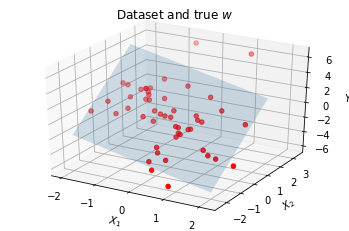

In [9]:
visualize_fun(true_w, 'Dataset and true $w$')

### Algorithm for Linear regression using GD with automatically computed derivatives
**Note:** This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorch" way in the next example.



In [29]:
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# Define hyperparameters
step_size = 0.1

# And starting w
w = torch.tensor([[1.], [0]], requires_grad=True)

zeroed_weights = []
zeroed_loss = []

print('iter,\tloss,\tw')
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    zeroed_loss.append(loss.item())
    zeroed_weights.append(w.view(2).detach().numpy()) #track these for graphing 
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    w.grad.detach()
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter,	loss,	w
0,	8.00,	[0.54773855 0.34919545]
1,	5.08,	[0.19440332 0.63384193]
2,	3.23,	[-0.08130664  0.8663093 ]
3,	2.06,	[-0.2961492  1.0565296]
4,	1.32,	[-0.4633026  1.2124883]
5,	0.85,	[-0.59312505  1.3406131 ]
6,	0.55,	[-0.6937539  1.4460858]
7,	0.36,	[-0.7715781  1.5330895]
8,	0.24,	[-0.8316104  1.6050065]
9,	0.16,	[-0.8777811  1.6645753]
10,	0.11,	[-0.91316926  1.714018  ]
11,	0.07,	[-0.94018483  1.7551396 ]
12,	0.05,	[-0.96071225  1.7894095 ]
13,	0.04,	[-0.97622335  1.8180262 ]
14,	0.03,	[-0.9878662  1.8419688]
15,	0.02,	[-0.9965352  1.8620387]
16,	0.02,	[-1.0029259  1.8788937]
17,	0.01,	[-1.0075781  1.8930742]
18,	0.01,	[-1.0109103  1.905025 ]
19,	0.01,	[-1.0132456  1.9151138]

true w		 [-1.  2.]
estimated w	 [-1.0132456  1.9151138]


### Things to avoid when using pytorch
**A tutorial that doesn't tell you how to do something wrong is no fun, so let's break pytorch**

**Why zero the grad?  What happens if we don't?**

We have to zero the gradient so it does not accumulate over time.  Below is an example of what happens to the weights in the linear regression with SGD example we saw previously if we don't zero them out. 

In [31]:
w = torch.tensor([[1.], [0]], requires_grad=True)

nonzeroed_weights = []
nonzeroed_loss = []

for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    nonzeroed_loss.append(loss.item())
    nonzeroed_weights.append(w.view(2).detach().numpy()) #track these for graphing 
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    #w.grad.detach()
    #w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())


true w		 [-1.  2.]
estimated w	 [-3.6005628  2.863611 ]


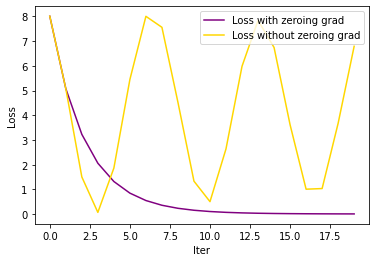

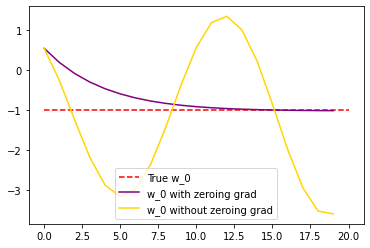

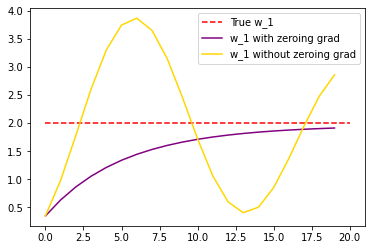

In [32]:
#plot loss first 

plt.plot(np.arange(20), zeroed_loss, label = 'Loss with zeroing grad', color = 'purple')
plt.plot(np.arange(20), nonzeroed_loss, label = 'Loss without zeroing grad', color = 'gold')
plt.legend()
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.show()

#what happens to the weights? 
#weight 0 
plt.plot([0,20], [true_w.view(2).numpy()[0]]*2, linestyle = '--', color = 'red', label = 'True w_0')
plt.plot(np.arange(20), np.vstack(zeroed_weights)[:,0], label = 'w_0 with zeroing grad', color = 'purple')
plt.plot(np.arange(20), np.vstack(nonzeroed_weights)[:,0], label = 'w_0 without zeroing grad', color = 'gold')
plt.legend()
plt.show()

#weight 1
plt.plot([0,20], [true_w.view(2).numpy()[1]]*2, linestyle = '--', color = 'red', label = 'True w_1')
plt.plot(np.arange(20), np.vstack(zeroed_weights)[:,1], label = 'w_1 with zeroing grad', color = 'purple')
plt.plot(np.arange(20), np.vstack(nonzeroed_weights)[:,1], label = 'w_1 without zeroing grad', color = 'gold')
plt.legend()
plt.show()


## torch.nn.Module

`Module` is PyTorch's way of performing operations on tensors. Modules are implemented as subclasses of the `torch.nn.Module` class. All modules are callable and can be composed together to create complex functions.


Note: most of the functionality implemented for modules can be accessed in a functional form via `torch.nn.functional`, but these require you to create and manage the weight tensors yourself. 

### Linear Module
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object. It is just a matrix multiplication and addition of bias:
\begin{align}
f(\m{X})=\m{X}\m{W}+\m{b}
\end{align}
where $\m{X}\in \mb{R}^{N\times d}$, $\m{W}\in \mb{R}^{d\times h}$ and $\m{b}\in \mb{R}^h$.

Unlike how we initialized our $\m{w}$
 manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in `torch.nn.init`. 

 





In [11]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transformed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight.detach())
print('b:', linear_module.bias.detach())

example_tensor torch.Size([2, 3])
transformed torch.Size([2, 4])

We can see that the weights exist in the background

W: tensor([[ 0.3918,  0.2644,  0.1949],
        [-0.3701,  0.2450, -0.2227],
        [ 0.3639, -0.1341, -0.2067],
        [-0.0110,  0.2018,  0.3380]])
b: tensor([ 0.5676, -0.2454,  0.0708, -0.4980])


### Activation functions
PyTorch implements a number of activation functions including but not limited to `ReLU`, `Tanh`, and `Sigmoid`. Since they are modules, they need to be instantiated.




In [12]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)


example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


### Sequential 
Many times, we want to compose Modules together. `torch.nn.Sequential` provides a good interface for composing simple modules.



In [13]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
    nn.Linear(d_in, d_hidden),
    nn.Tanh(),
    nn.Linear(d_hidden, d_out),
    nn.Sigmoid()
)

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


Note: we can access all of the parameters (of any `nn.Module`) with the `parameters()` method.



In [14]:
params = model.parameters()

for param in params:
    print(param.detach())


tensor([[ 0.4467,  0.1278,  0.4927],
        [-0.2266,  0.2621, -0.0352],
        [ 0.2423, -0.4031,  0.4378],
        [-0.2061,  0.5175, -0.3973]])
tensor([-0.0227,  0.1744, -0.0513, -0.1545])
tensor([[ 0.3247, -0.4757,  0.0047, -0.3389]])
tensor([-0.2276])


### Loss functions
PyTorch implements many common loss functions including `MSELoss` and `CrossEntropyLoss`.

PyTorch implements a version of the cross entropy loss in one module called `CrossEntropyLoss`. Its usage is slightly different than MSE, so we will break it down here.

- input: The first parameter to CrossEntropyLoss is the output of our network. It expects a real valued tensor of dimensions $(N,C)$ where $N$ is the minibatch size and $C$ is the number of classes. In our case $N=3$ and $C=2$. The values along the second dimension correspond to raw unnormalized scores for each class. The CrossEntropyLoss module does the softmax calculation for us, so we do not need to apply our own softmax to the output of our neural network.

- output: The second parameter to CrossEntropyLoss is the true label. It expects an integer valued tensor of dimension $(N)$. The integer at each element corresponds to the correct class. In our case, the "correct" class labels are class 0, class 1, and class 1.
Try out the loss function on three toy predictions. The true class labels are $y=[1,1,0]$. The first two examples correspond to predictions that are "correct" in that they have higher raw scores for the correct class. The second exam




In [15]:
mse_loss_fn = nn.MSELoss()
CE_loss_fn  = nn.CrossEntropyLoss()
input = torch.tensor([[0.8, 0.1, -0.4]])
target = torch.tensor([[1., 0, -1]])

mse_loss = mse_loss_fn(input, target)
CE_loss  = CE_loss_fn(input,target)

print(mse_loss)
print(CE_loss)



tensor(0.1367)
tensor(-1.2000)


In [16]:
#input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = CE_loss_fn(input, target)
print(output)

tensor(0.0025)


## torch.optim
PyTorch implements a number of gradient-based optimization methods in `torch.optim`, including Gradient Descent. At the minimum, it takes in the model parameters and a learning rate.

Optimizers do not compute the gradients for you, so you must call `backward()` yourself. You also must call the `optim.zero_grad()` function before calling `backward()` since by default PyTorch does and inplace add to the `.grad` member variable rather than overwriting it.

This does both the `detach_()` and `zero_()` calls on all tensor's grad variables.

In [26]:
# create a simple model
model = nn.Linear(1, 1, bias=True)


# create a simple dataset
x = torch.randn([n,1])
X = torch.cat((torch.ones([n,1]), x),1)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(x)
print('model params before:', model.weight.detach())
print('bias params before:', model.bias.detach())
loss = mse_loss_fn(y_hat, y)
optim.zero_grad()
loss.backward()
optim.step()
print('model params after:', model.weight.detach())
print('bias params after:', model.bias.detach())


model params before: tensor([[0.2374]])
bias params before: tensor([-0.5227])
model params after: tensor([[0.2659]])
bias params after: tensor([-0.5342])


As we can see, the parameter was updated in the correct direction

## Example 2: Linear regression using GD with torch.nn module
Now let's combine what we've learned to solve linear regression in a "PyTorch" way.



In [27]:
model = nn.Linear(1, 1, bias=True)
mse_loss_fn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)

print('iter,\tloss,\tw,\t\tbias')

zeroed_weights = []
zeroed_bias = []
zeroed_loss = []

for i in range(25):
    y_hat = model(x)
    loss = mse_loss_fn(y_hat, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    zeroed_loss.append(loss.item())
    zeroed_weights.append(model.weight.detach().numpy()) #track these for graphing 
    zeroed_bias.append(model.bias.detach().numpy())

    print('{},\t{:.2f},\t{},\t{}'.format(i, loss.item(), model.weight.detach().numpy(), model.bias.detach().numpy() ))


print('\ntrue bias and w \t\t', true_w.view(2).numpy())
print('estimated weight and bias\t', model.weight.detach().numpy(),  model.bias.detach().numpy())

iter,	loss,	w,		bias
0,	2.59,	[[0.648092]],	[-0.5147025]
1,	1.77,	[[0.8679258]],	[-0.6268537]
2,	1.21,	[[1.0516515]],	[-0.7139451]
3,	0.83,	[[1.2052791]],	[-0.7814206]
4,	0.58,	[[1.3338033]],	[-0.8335633]
5,	0.40,	[[1.4413776]],	[-0.8737402]
6,	0.28,	[[1.5314584]],	[-0.9045949]
7,	0.20,	[[1.6069238]],	[-0.92820114]
8,	0.14,	[[1.670172]],	[-0.94618344]
9,	0.10,	[[1.7232023]],	[-0.95981276]
10,	0.07,	[[1.7676829]],	[-0.97008187]
11,	0.05,	[[1.805006]],	[-0.97776514]
12,	0.04,	[[1.8363345]],	[-0.9834653]
13,	0.03,	[[1.8626401]],	[-0.9876507]
14,	0.03,	[[1.8847356]],	[-0.99068433]
15,	0.02,	[[1.9033003]],	[-0.99284697]
16,	0.02,	[[1.9189031]],	[-0.994355]
17,	0.02,	[[1.9320203]],	[-0.9953748]
18,	0.01,	[[1.9430509]],	[-0.9960337]
19,	0.01,	[[1.952329]],	[-0.9964289]
20,	0.01,	[[1.9601351]],	[-0.99663407]
21,	0.01,	[[1.9667041]],	[-0.9967049]
22,	0.01,	[[1.9722334]],	[-0.99668294]
23,	0.01,	[[1.9768885]],	[-0.99659926]
24,	0.01,	[[1.9808085]],	[-0.9964766]

true bias and w 		 [-1.  2.]
esti

## Example 3: Linear regression using SGD
In the previous examples, we computed the average gradient over the entire dataset (Gradient Descent). We can implement Stochastic Gradient Descent with a simple modification.



In [19]:
step_size = 0.01
model = nn.Linear(1, 1, bias=True)
mse_loss_fn = nn.MSELoss()

optim = torch.optim.SGD(model.parameters(), lr=step_size)
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x_idx = x[rand_idx] 
    y_hat = model(x_idx)
    loss = mse_loss_fn(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 20 == 0:
        print('{},\t{:.2f},\t{},\t{}'.format(i, loss.item(), model.weight.detach().numpy(), model.bias.detach().numpy() ))

print('\ntrue bias and w \t\t', true_w.view(2).numpy())
print('estimated weight and bias\t', model.weight.detach().numpy(),  model.bias.detach().numpy())

0,	1.57,	[[0.31709412]],	[0.7387173]
20,	1.35,	[[1.3365093]],	[0.15090148]
40,	0.53,	[[1.8588203]],	[-0.22880341]
60,	0.12,	[[1.8819257]],	[-0.48268867]
80,	0.27,	[[1.9117095]],	[-0.658806]
100,	0.08,	[[1.8782121]],	[-0.74685085]
120,	0.05,	[[1.9593239]],	[-0.84884906]
140,	0.01,	[[1.982178]],	[-0.91154444]
160,	0.00,	[[1.9972583]],	[-0.94314396]
180,	0.00,	[[1.9968369]],	[-0.9665506]

true bias and w 		 [-1.  2.]
estimated weight and bias	 [[2.0065799]] [-0.9604592]


## Neural Network Basics in PyTorch
We will try and fit a simple neural network to the data.



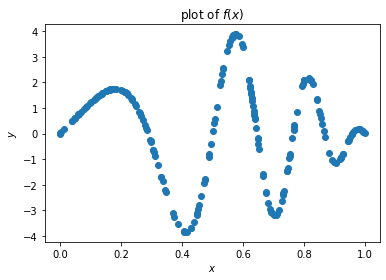

In [20]:
d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

Here we define a simple two hidden layer neural network with Tanh activations. There are a few hyper parameters to play with to get a feel for how they change the results.

### Gradient descent
Here we use the gradient descent. You can try to modify it for actual SGD. 



In [21]:
# feel free to play with these parameters

step_size = 0.05
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))

iter,	loss
0,	3.59
600,	3.43
1200,	2.96
1800,	1.97
2400,	1.07
3000,	0.98
3600,	0.63
4200,	0.42
4800,	0.30
5400,	0.23


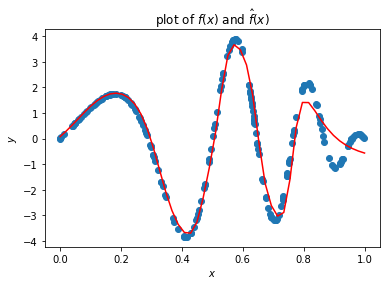

In [22]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

### Momentum
There are other optimization algorithms besides stochastic gradient descent. One is a modification of GD called momentum. 

We only change the step size and add the momentum keyword argument to the optimizer. Notice how it reduces the training loss in fewer iterations.



In [23]:
# feel free to play with these parameters

step_size = 0.05
momentum = 0.9
n_epochs = 1500
d = X.shape[1]
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
    nn.Linear(d, n_hidden_1), 
    nn.Tanh(),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.Tanh(),
    nn.Linear(n_hidden_2, d_out)
)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))

iter,	loss
0,	3.59
150,	3.24
300,	1.17
450,	0.25
600,	0.18
750,	0.07
900,	0.04
1050,	0.03
1200,	0.01
1350,	0.03


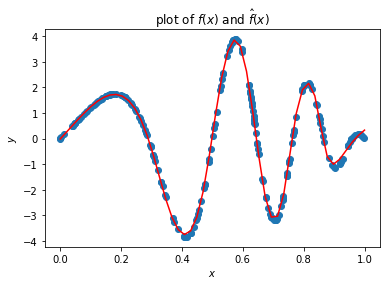

In [24]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Learning rate schedulers
Often we do not want to use a fixed learning rate throughout all training. PyTorch offers learning rate schedulers to change the learning rate over time. Common strategies include multiplying the lr by a constant every epoch (e.g. 0.9) and halving the learning rate when the training loss flattens out.

See the [learning rate scheduler docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for usage and examples